In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

## 1.
Para los siguientes modelos vistos en los temas anteriores realizá pruebas:

### a.
``cs_nh`` una prueba predictiva a priori, todos los grupos juntos


In [3]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [3]:
cs_data

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64
...,...,...,...,...
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36


In [13]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample_prior_predictive(samples=100)

Sampling: [y, μ, σ]


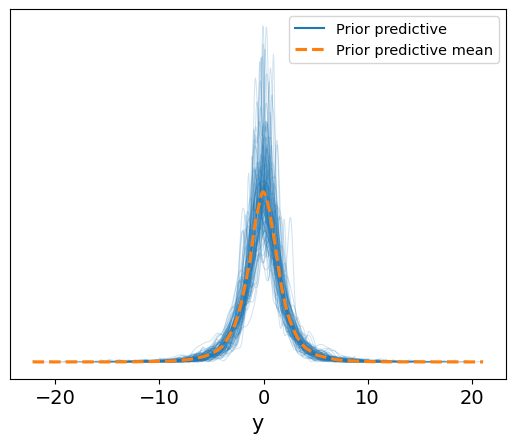

In [5]:
az.plot_ppc(idata, group="prior", kind="kde");

Los datos generados sólo con los priors parecen ser plausibles. Pero podría ver que pasa si los hago menos informativos.

Sampling: [y, μ, σ]


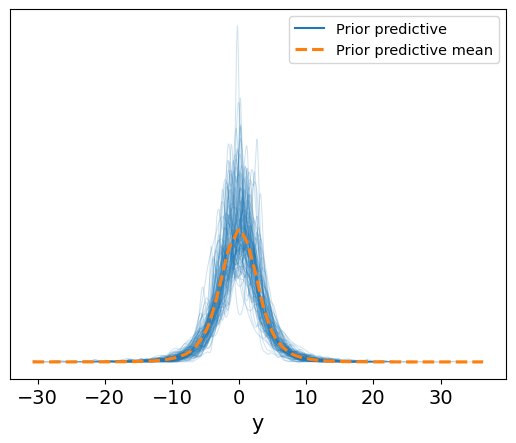

In [6]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=2, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=3, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample_prior_predictive(samples=100)
az.plot_ppc(idata, group="prior", kind="kde");

A pesar de no saber nada sobre desplazamientos quimicos supongo, al ver la data, que una differencia de 10 deberia ser casi imposible y, por lo tanto, debería volver a usar los priors de antes.  
Si tuviera conocimiento en el area no debería ver los datos para saber si una diferencia es absurda o imposible, podría usar usando valores de referencia.

### b. 
``cs_nh`` una prueba predictiva a posteriori, todos los grupos juntos

In [14]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


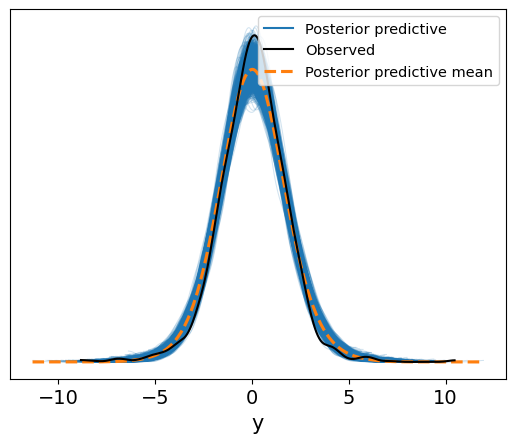

In [8]:
az.plot_ppc(idata);

Se parece bastante pero prodría ser mejor, quizás cambiar los priors para que la _posterior predictive mean_ se acerqué más a la diff observada en el cero. En realidad es innecesario pero ya que estamos vamos a ver que pasa.

In [9]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=0.1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=1, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff)
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\nazar\anaconda3\envs\estadistica_2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


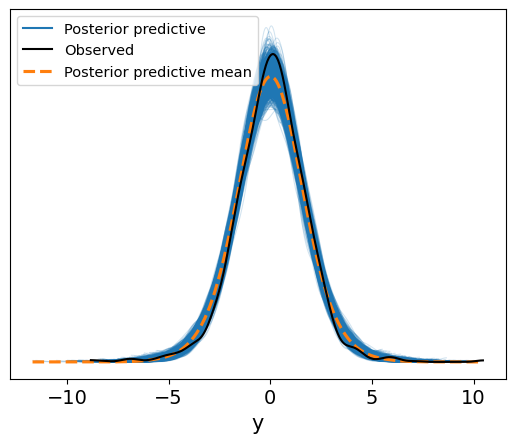

In [10]:
az.plot_ppc(idata);

Los priors son mucho más informativos y la posterior predictive no cambia mucho. Es mejor usar priors que sean solo levemente informativos

### c.
``cs_nh`` una prueba predictiva a posteriori, los 19 grupos por separado

Tuve que cambiar como estaba definido el modelo, espero que no cambie nada (PROBAR)

In [3]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories, "aa_flat": cat_encode.categories[idx]}

In [4]:

with pm.Model(coords=coords) as cs_nh:
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa")
    σ = pm.HalfNormal('σ', sigma=2, dims="aa")

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff, dims="aa_flat")
    idata = pm.sample(1000)
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

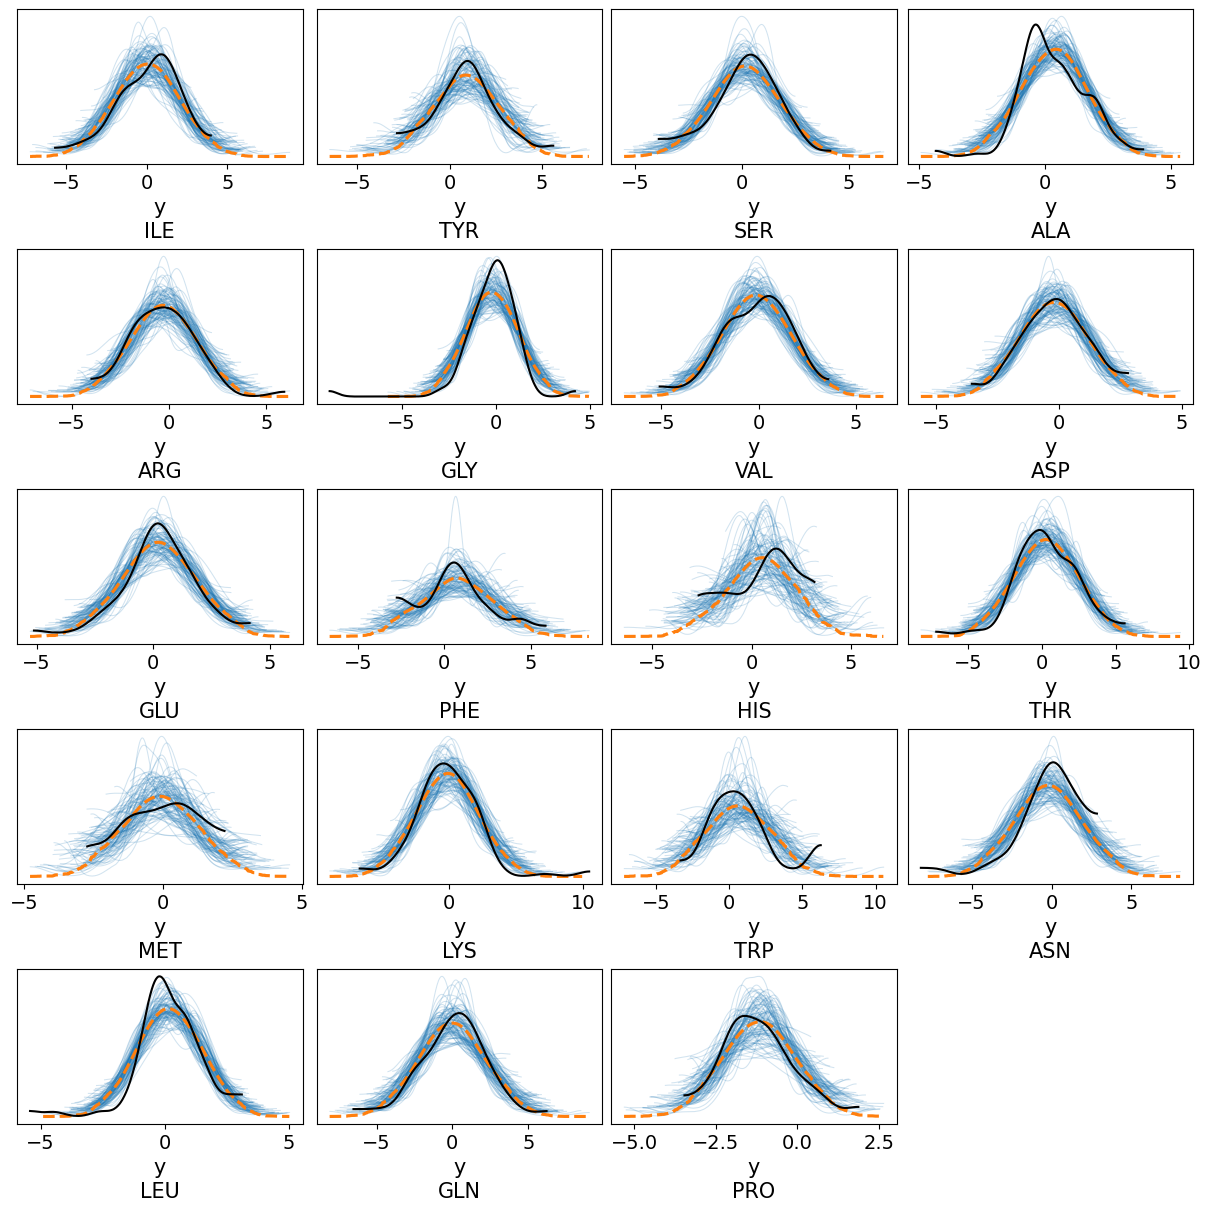

In [22]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_ppc(
    idata,
    coords = {"aa_flat": [cat_encode.categories]},
    flatten=[],
    num_pp_samples=100,
    ax=ax,
    legend=False,
);

Parece que, salvo para un par de grupos, el modelo predice bien los datos observados.  
Siendo que hay 19 grupos, el hecho de que no prediga muy bien a un grupo (HIS) no creo que sea importante.

Puede ser que usar un modelo jerarquico mejore estos resutlados.

In [23]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    # μ_mu = pm.Normal('μ_mu', mu=0, sigma=2)
    μ_mu = pm.Uniform('μ_mu', lower=-3, upper=3)
    μ_sd = pm.HalfNormal('μ_sd', 2)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff, dims="aa_flat")

    idata_cs_h = pm.sample(1000)
    idata_cs_h.extend(pm.sample_posterior_predictive(idata_cs_h))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

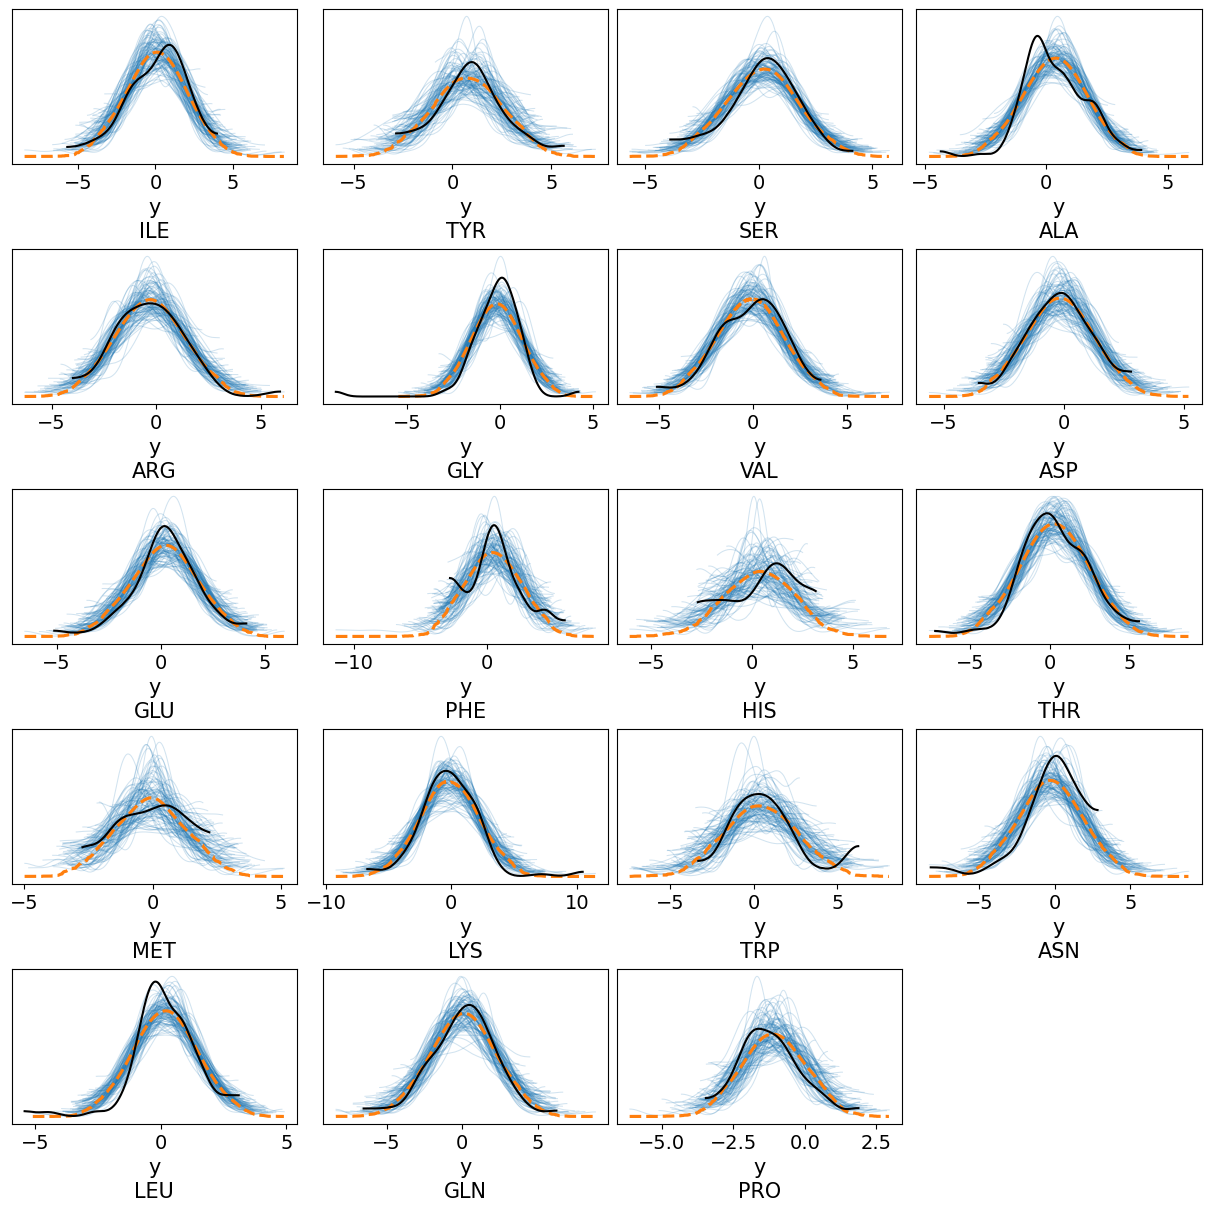

In [24]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_ppc(
    idata_cs_h,
    coords = {"aa_flat": [cat_encode.categories]},
    flatten=[],
    num_pp_samples=100,
    ax=ax,
    legend=False,
);

No, es practicamente lo mismo.

## 2. 
Usando un modelo construido para tus propios datos realizá una prueba predictiva a priori y en función del resultado modificá los priors elegidos.

## 3.
Usando la función ``az.plot_bpv`` y sobre la distribución a posteriori del modelo ``cs_nh`` realizá:

### a.
Un gráfico de los p-valores marginales, para todos los grupos juntos.

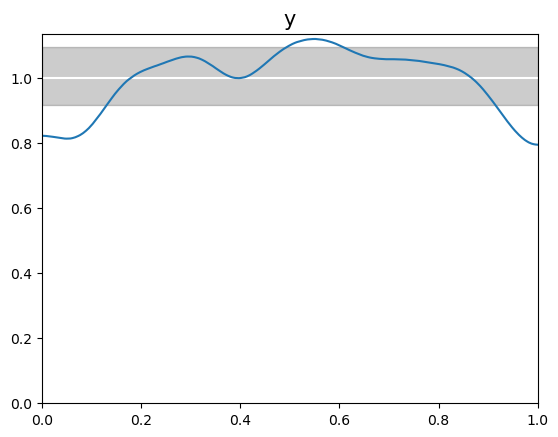

In [16]:
az.plot_bpv(idata);

El grafico debería estar en el rango gris, esto quiere decir que la data observada no pudo haber sido generada por el modelo ``cs_nh``.

### b.
Un gráfico de los p-valores marginales, para los 19 grupos por separado.

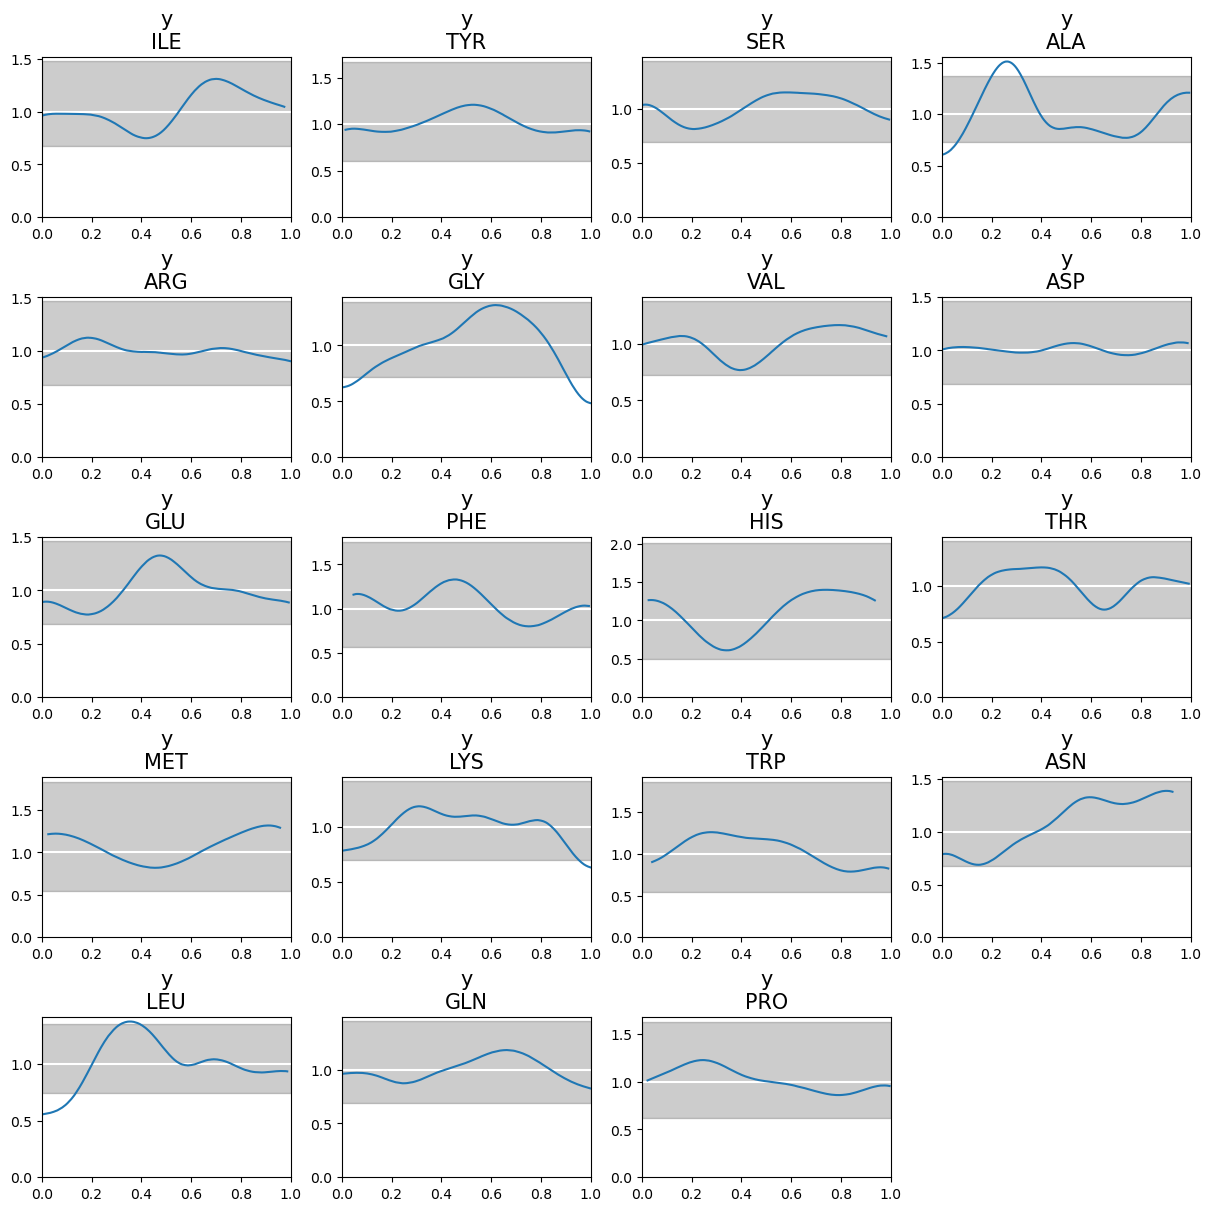

In [26]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_bpv(
    idata,
    coords = {"aa_flat": [cat_encode.categories]},
    ax=ax,
    flatten=[]
);

In [30]:
cs_data["aa"].value_counts()

aa
LEU    159
ALA    142
VAL    138
GLY    132
THR    124
LYS    117
SER    108
GLN    103
ASP     99
GLU     99
ARG     98
ILE     94
ASN     93
PRO     61
TYR     55
PHE     46
MET     40
TRP     38
HIS     30
Name: count, dtype: int64

LEU, LYS, ALA, GLY generan problemas y son clases con mucha representación en la data, tendrá algo que ver con lo anterior? (INVESTIGAR)

### c. 
Un gráfico de los p-valores para un estadístico a su elección que no sea la media, para los 19 grupos por separado.

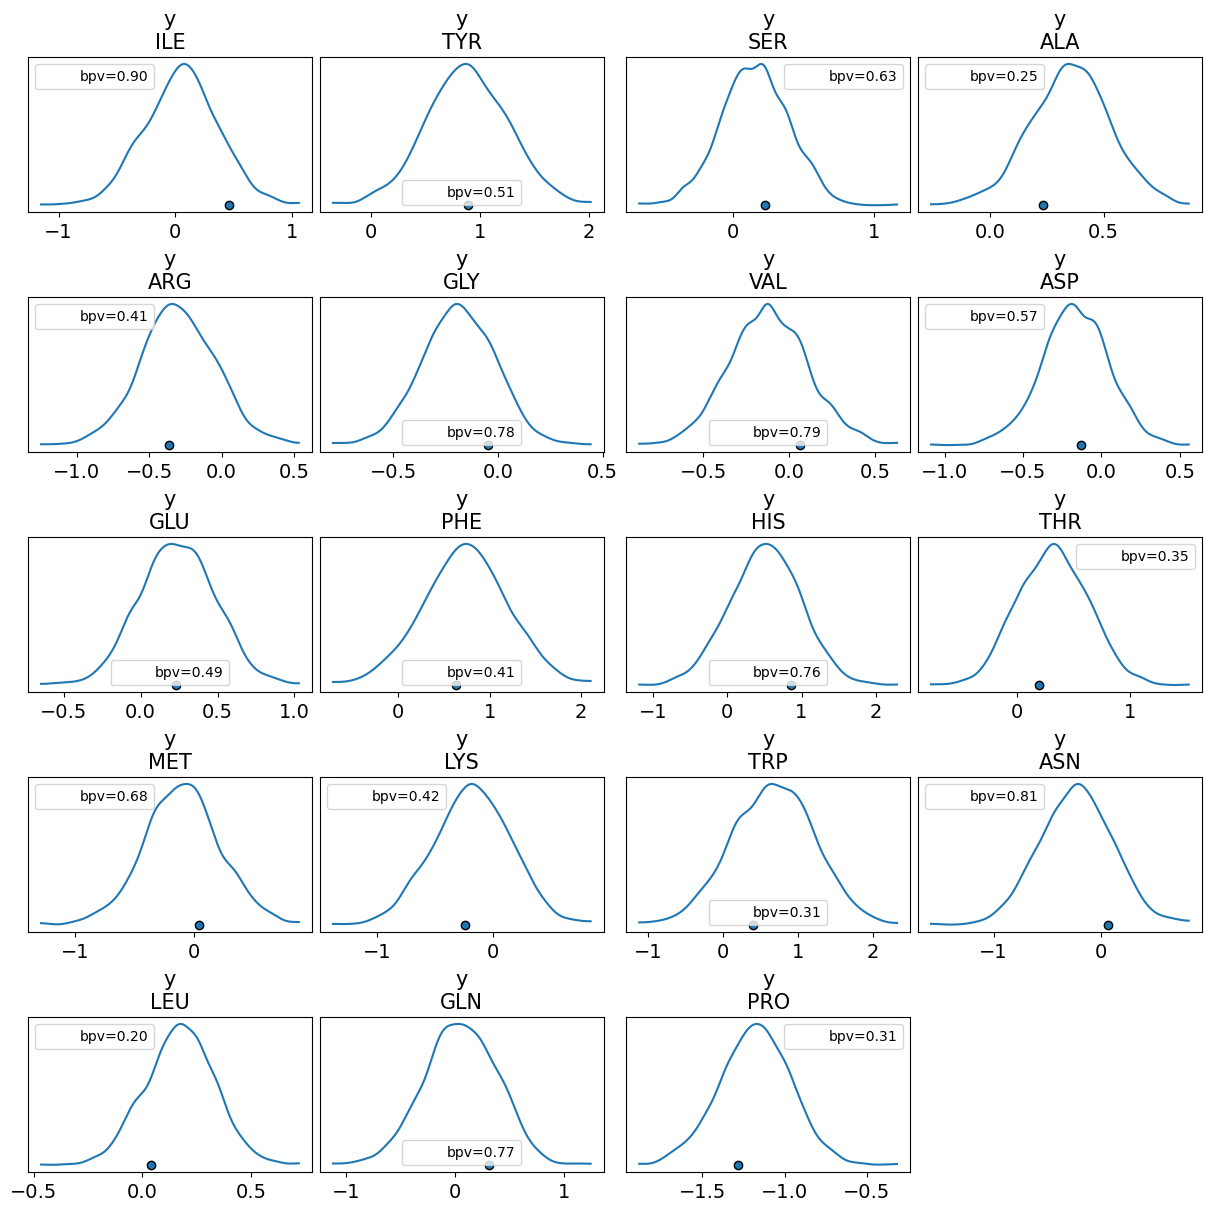

In [7]:
fig, ax = plt.subplots(5, 4, figsize=(12, 12), constrained_layout=True)
fig.delaxes(ax.flatten()[-1])
ax = ax.flatten()[:19]
az.plot_bpv(
    idata,
    kind="t_stat",
    t_stat="median",
    coords = {"aa_flat": [cat_encode.categories]},
    ax=ax,
    flatten=[]
);

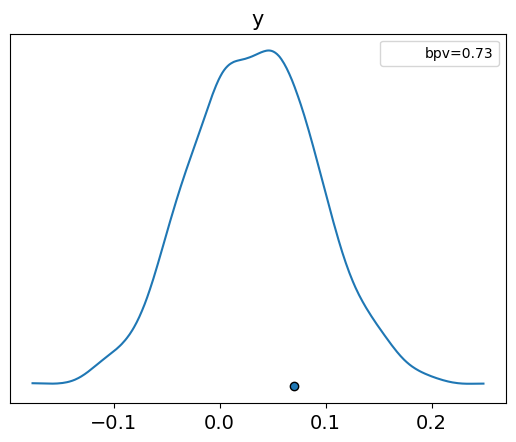

In [26]:
az.plot_bpv(
    idata,
    kind="t_stat",
    t_stat="median"
);

No es el resultado optimo, como la mediana no está de manera explicita en el modelo esto podía pasar.

# 4.
Para ganar intuición sobre los gráficos de p-valores marginales. Vamos a hacer el siguiente experimento. Vamos a crear 4 InferenceData, todos con el mismo grupo "observed_data" y con 200 observaciones (extra, podés probar cambiar el número de observaciones).
+ Uno de ellos con predicciones que provengan de una distribución más ancha que la observada
+ Otro con una predicciones que provengan de una distribución más angosta
+ El tercero con la media desplazada respecto de la observada
+ El cuarto con muestra de la misma distribución que la observada.

Explicá las observaciones.

# Bayes Factors vs LOO (PSIS-LOO-CV)

Algunas de las diferencias de estas formas de comparar modelos son:
+ Los factores de Bayes comparan los modelos basándose en que tan bien explican los datos observados, mientras que LOO evalua su exactitud predictiva.
+ BF depede mucho más de los _priors_ elegidos ya que usa el calculo de la _likelihood marginal_.
+ BF tiene un costo computacional generalmente alto por tener que calcular integrales o SMC.
+ Calculando BF solo sabremos que modelo es mejor mientras que al calcular LOO con pymc obtenemos más información, como el error estandar, una aproximación del número efectivo de parámetros, etc.

# Diagnostico de un modelo visto